In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from pathlib import Path
from math import trunc
%matplotlib inline

In [24]:
# Retreive all the data from the meta-data_epoch file
meta_data = ascii.read('../dataredred/J0600_meta-data_epoch.txt')

epoch_arr = np.array(meta_data["EPOCH"])

filters = np.array(meta_data["FILTER"]) # Filters of all the .fits images
airmass_arr = np.array(meta_data["AIRMASS"]) # Airmasses for all the .fits images

fits_name_arr = np.array(meta_data["IMAGE"]) # Name of the original .fits file
files_arr = np.array(meta_data["FILENAME"]) # Name of the data reduced files

N_files = len(epoch_arr) #nr of files
N_stars = len(ascii.read(files_arr[0])["STARNR"])-1 #nr of stars
print ("Number of files = {}".format(N_files))
print ("Number of stars = {}".format(N_stars))

Number of files = 1656
Number of stars = 20


In [30]:
# Make a mask for all the filters:
filt = [] #list of the different filters
NimgINf = {} #dictionary of number of images for each filter
for f in filters:
    if f not in filt:
        filt.append(f)
        NimgINf[f] = 1
    else:
        NimgINf[f] +=1
print (filt)
print (NimgINf)

fmask = {}
for f in filt:
    fmask[f] = filters == f

    
# Retreive the flux and fluxerr data from all the other files
flux_tmp = np.zeros((N_files,N_stars+1))
fluxerr_tmp = np.zeros((N_files,N_stars+1))

for i in range(N_files):
    file = files_arr[i]
    
    filecontent = ascii.read(file)
    flux_tmp[i] = np.array(filecontent["FLUX"])
    fluxerr_tmp[i] = np.array(filecontent["FLUXERR"])

print (np.shape(flux_tmp))
print (np.shape(fluxerr_tmp))


# Make a dictionary where flux[filter] gives an array with all the data for that filter
# And do the same for epoch, airmass, fits_name and files
J0600_flux = {}
J0600_fluxerr = {}
flux = {}
fluxerr = {}

epoch = {}
airmass = {}
fits_name = {}
files = {}

for f in filt:
    J0600_flux[f] = flux_tmp[fmask[f]][:,0]
    J0600_fluxerr[f] = fluxerr_tmp[fmask[f]][:,0]
    flux[f] = flux_tmp[fmask[f]][:,1:]
    fluxerr[f] = fluxerr_tmp[fmask[f]][:,1:]
    
    epoch[f] = epoch_arr[fmask[f]]
    airmass[f] = airmass_arr[fmask[f]]
    fits_name[f] = fits_name_arr[fmask[f]]
    files[f] = files_arr[fmask[f]]


['gp', 'ip', 'rp']
{'gp': 743, 'ip': 601, 'rp': 312}
(1656, 21)
(1656, 21)


In [46]:
# Retreive the data from the meta-data_stars file
meta_data_stars = ascii.read("../dataredred/J0600_meta-data_stars.txt")

J0600_coords = [meta_data_stars[filt[0]+'_RA'][0],meta_data_stars[filt[0]+'_Dec'][0]]

original_starnr = {}
star_coords = {}
for f in filt:
    original_starnr[f] = np.array(meta_data_stars[f+"_star"][1:])
    
    RA = meta_data_stars[f+'_RA'][1:]
    Dec = meta_data_stars[f+'_Dec'][1:]
    star_coords[f] = np.array([RA,Dec]).transpose()

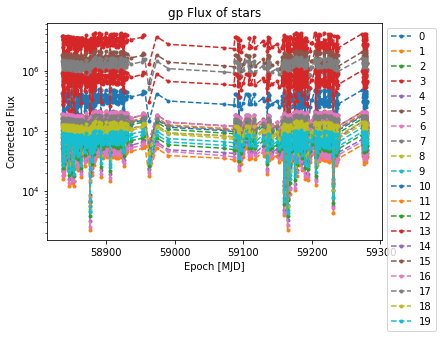

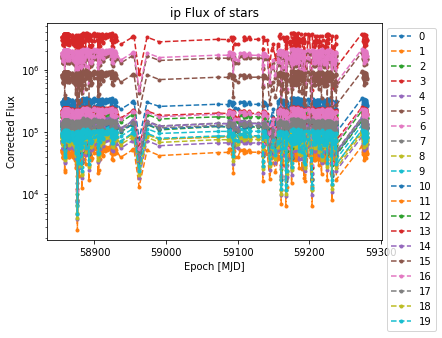

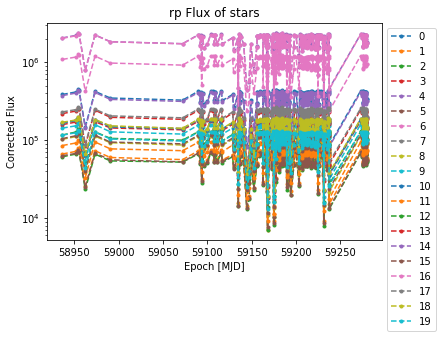

In [47]:
# Try the data
for f in filt:
    for s in range(N_stars):
        plt.plot(epoch[f],flux[f][:,s],linestyle='dashed',marker='.',label=s)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.title(f+" Flux of stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()

# Extract magnitudes from Gaia DR2 (or EDR3?) & use for flux -> mag

In [48]:
# Extract the magnitudes from the stars in 400" radius around J0600
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

# Coords of J0600: 90.00316332976436 -31.007910088843165
coord = SkyCoord(ra=90.003163, dec=-31.007910, unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(400, u.arcsec)
Gaia.ROW_LIMIT = -1
j = Gaia.cone_search_async(coord, radius)
r = j.get_results()
r.pprint()

INFO: Query finished. [astroquery.utils.tap.core]
    solution_id             designation          ...          dist         
                                                 ...                       
------------------- ---------------------------- ... ----------------------
1635721458409799680 Gaia DR2 2891196718939580672 ... 0.00013201426578689563
1635721458409799680 Gaia DR2 2891196684579844864 ...   0.009094052279059428
1635721458409799680 Gaia DR2 2891196753298345472 ...   0.010658205399898254
1635721458409799680 Gaia DR2 2891196684579845376 ...   0.011317279008876314
1635721458409799680 Gaia DR2 2891196753297490304 ...   0.012358430209092582
1635721458409799680 Gaia DR2 2891196920800325760 ...   0.013193050363307734
1635721458409799680 Gaia DR2 2891196753299317632 ...   0.013872023467184842
1635721458409799680 Gaia DR2 2891196680282145152 ...    0.01664899863064252
1635721458409799680 Gaia DR2 2891196684578034688 ...   0.016696369787614993
1635721458409799680 Gaia DR2 289119692

In [49]:
# To link the correct Gaia entries to our stars, select star with nearest coordinates
filt2 = ['gp','rp']

def find_stars(xobj_list, yobj_list, xlist, ylist, f):
    # Make a matrix with each column the same xlist or ylist.
    # The number of columns is the number of objects in standards.txt
    xmatrix = np.array(list(xlist)*len(xobj_list)).reshape([len(xobj_list),len(xlist)]).transpose()
    ymatrix = np.array(list(ylist)*len(yobj_list)).reshape([len(yobj_list),len(ylist)]).transpose()
    
    distance_matrix = np.sqrt((xmatrix-xobj_list)**2 + (ymatrix-yobj_list)**2)
    
    indices = np.argmin(distance_matrix, axis=0)
    """
    # Make plot to check data
    plt.figure(figsize=(16,16))
    plt.scatter(xlist,ylist,c='b',s=4)
    plt.scatter(xobj_list, yobj_list, c='red', s=2)
    plt.plot([2000,2025],[0,0],c='r')
    for i in range(nr_stars):
    	plt.plot([xobj_list[i],xlist[indices[i]]],[yobj_list[i],ylist[indices[i]]], linestyle='dashed',c='r',linewidth=1)
    plt.title(f)
    plt.show()
    """
    return indices, np.diag(distance_matrix[indices])
    #the diagonal gives the distance from each selected object to the closest object

def distance(xobj,yobj, xlist,ylist):
    'find the distance between target & objects round it, returns list with distances in pixels'
    d = (xobj-xlist)**2 + (yobj-ylist)**2
    return np.sqrt(d)

In [52]:
# Making a mask for the gaia data to extract the data from the relevant stars
gaiamask = {}
for f in filt:
    stars_arg, d = find_stars(star_coords[f][:,0],star_coords[f][:,1],np.array(r['ra']),np.array(r['dec']),f)
    gaiamask[f] = stars_arg
    max_d = 1 #if distance is bigger than 1", it is to much
    if np.sum(d >= max_d) != 0:
        print ("Stars that are too distant")
        print (f, np.arange(N_stars)[d >= max_d])
    plt.show()

# Making a dictionary for the gaia magnitude of the selected stars
gaia_mag = {}
gaia_mag[filt[0]] = np.array(r['phot_g_mean_mag'][gaiamask[filt[0]]]) #gaia filter g, not gp
gaia_mag[filt[2]] = np.array(r['phot_rp_mean_mag'][gaiamask[filt[2]]])

In [53]:
# Extract the Gaia J0600 data
# Coords of J0600: 90.00316332976436 -31.007910088843165
d = distance(90.00316332976436, -31.007910088843165, r['ra'],r['dec'])

J0600_gaia = r[np.argmin(d)]

print (J0600_gaia['dec'])
print (J0600_gaia['astrometric_pseudo_colour'])

-31.00780455726246
1.467553481950413


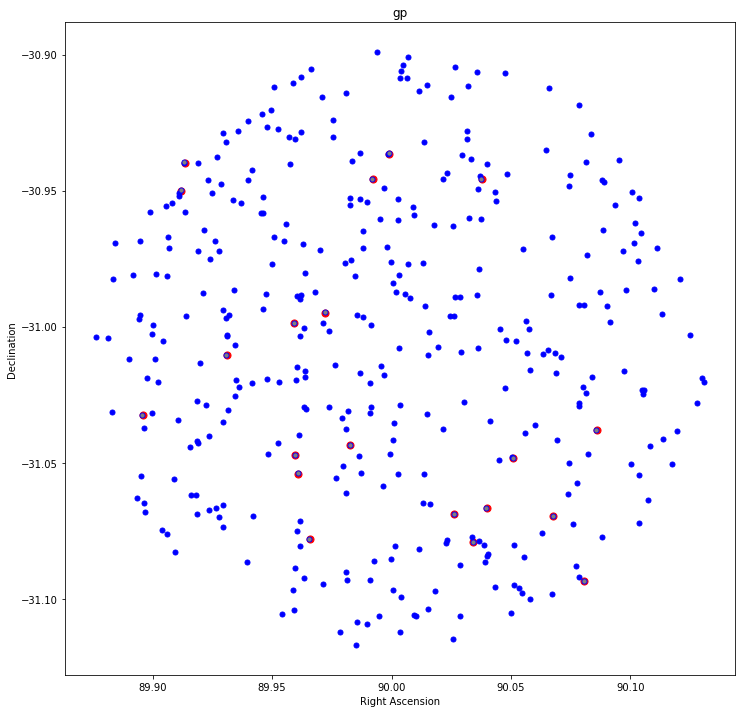

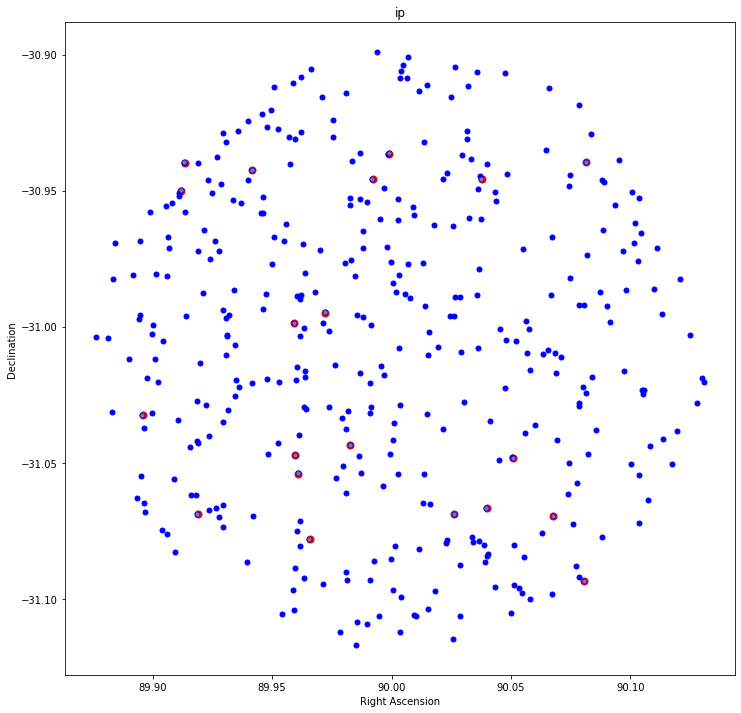

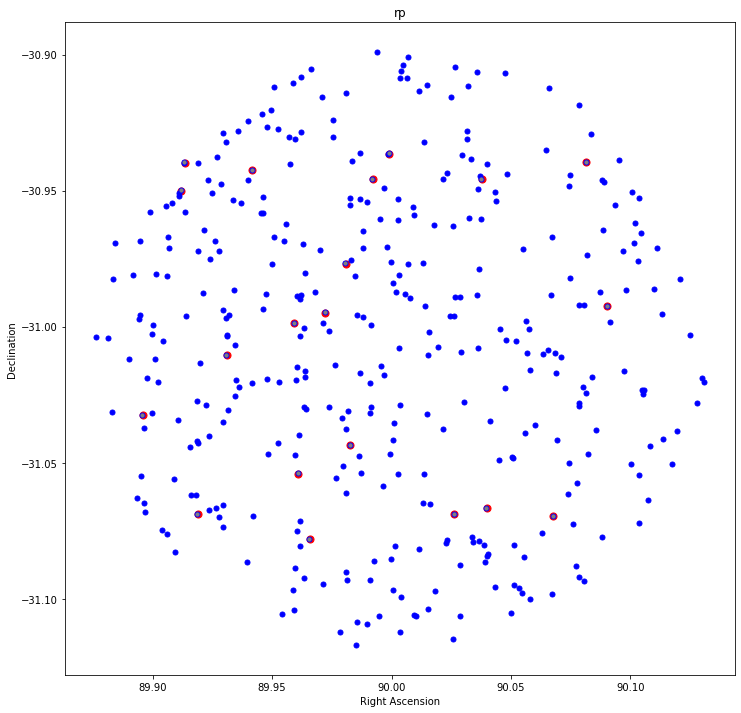

In [54]:
# Make a plot to check if the right stars are selected
for f in filt:
    plt.figure(figsize=(12,12))
    #plt.scatter(standards['RA'][0],standards['Dec'][0], c='r',s=15)
    plt.scatter(star_coords[f][:,0],star_coords[f][:,1], c='r',s=50)
    plt.scatter(r['ra'],r['dec'],c='b',s=25)
    plt.scatter(r['ra'][gaiamask[f]],r['dec'][gaiamask[f]],c='grey',s=10)
    plt.xlabel("Right Ascension")
    plt.ylabel("Declination")
    #plt.axis(xmin=89.90,xmax=89.94,ymin=-30.96,ymax=-30.92)
    #plt.axis(xmin=89.86,xmax=90.01,ymin=-31.02,ymax=-30.88)
    plt.title(f)
    plt.show()

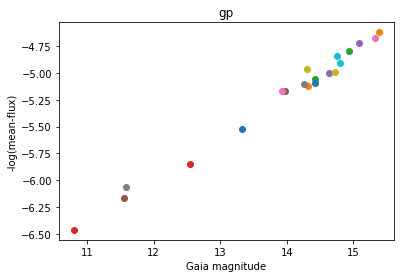

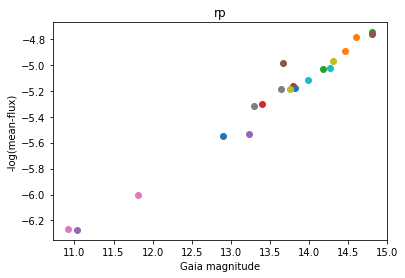

20


In [64]:
# Making a plot of the gaia magnitude on x-axis and -log(meanflux) on the y axis for selected stars
#  if all is well, this should result in a straight line.

for f in ['gp','rp']:
    for s in range(N_stars):
        nonNaN = np.isnan(flux[f][:,s])==False
        plt.scatter(gaia_mag[f][s],-1*np.log10(np.mean(flux[f][:,s][nonNaN])))
    plt.title(f)
    plt.xlabel("Gaia magnitude")
    plt.ylabel("-log(mean-flux)")
    plt.show()
print (len(gaia_mag['gp']))

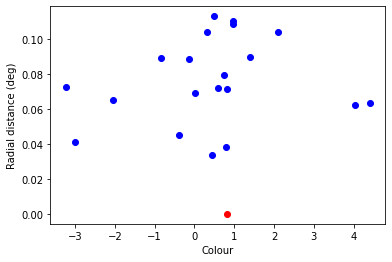

/home/bartjuh60/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


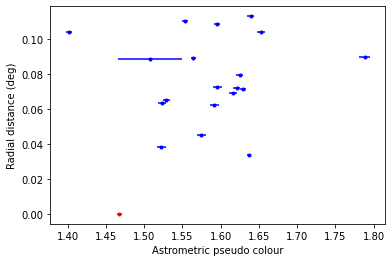

In [61]:
# Radial distance to J0600 plotted as function of colour
d_to_J0600 = distance(90.00316332976436, -31.007910088843165,r['ra'][gaiamask['rp']],r['dec'][gaiamask['rp']])

plt.scatter(gaia_mag['gp']-gaia_mag['rp'], d_to_J0600,c='b')
plt.scatter(J0600_gaia['phot_g_mean_mag']-J0600_gaia['phot_rp_mean_mag'],np.min(d),c='r')
plt.xlabel('Colour')
plt.ylabel('Radial distance (deg)')
plt.show()

plt.errorbar(r['astrometric_pseudo_colour'][gaiamask['rp']], d_to_J0600,\
             xerr = r['astrometric_pseudo_colour_error'][gaiamask['rp']],fmt='.', c='b')
plt.errorbar(J0600_gaia['astrometric_pseudo_colour'],np.min(d),\
             xerr=J0600_gaia['astrometric_pseudo_colour_error'],fmt='.',c='r')
plt.xlabel('Astrometric pseudo colour')
plt.ylabel('Radial distance (deg)')
plt.show()

# After this point, the code does not work

In [63]:
# calculating guess for zeropoint:
def linear(x,a,b):
    return a*x+b

popt, pcov = optimize.curve_fit(linear, -2.5*np.log10(meanflux_star[f][var_mask[f]]), gaia_mag[f])
print (popt)
print (pcov)

NameError: name 'optimize' is not defined

In [ ]:
#def mag_correction(F, a0, a1, a2):#, a3, a4):
#    
#    mx = -2.5*np.log10(F)
#    
#    mtrue = mx + a0 + a1*X + a2*c #+ a3*c*X + a4 * c**2 #could do a5*c**2 + a6*c**2 + ....
#    return mtrue


#popt, pcov = optimize.curve_fit(mag_correction, flux, gaia_mag[f], p0=[27,1,1])
#print (popt)
#print (pcov)


In [ ]:
from scipy import optimize

def mag(F, params):
    #a0, a1, a2 = params
    a0,a1 = params
    
    mx = -2.5*np.log10(F)
    
    return mx + a0 #+ a1*X #+ a2*c

def mag_min(params, F):
    #a0, a1, a2 = params
    a0,a1 = params
    
    mx = -2.5*np.log10(F)
    mtrue = mx + a0 #+ a1*X #+ a2*c #+ a3*c*X + a4 * c**2 #could do a5*c**2 + a6*c**2 + ....
    
    return np.sum((gaia_mag[f]-mtrue)**2)

c = gaia_mag['gp']-gaia_mag['rp']

fit_result = {}
chisq = {}
for f in filt2:
    tmp = []
    tmp2 = []
    for e in range(len(corepoch[f])):
        X = corairmass[f][e]
        flux = corflux[f].transpose()[var_mask[f]].transpose()[e]
        
        res = optimize.minimize(mag_min, [27,0.1],flux)
        #print (mag_min(res.x,flux))
        tmp.append(np.array(res.x))
        tmp2.append(mag_min(res.x,flux))
    fit_result[f] = np.array(tmp)
    chisq[f] = np.array(tmp2)


In [ ]:
for f in filt2:
    print (chisq[f])

In [ ]:
for f in ['gp','rp']:
    #print (fit_result[f])
    plt.figure(figsize=(10,10))
    for e in range(len(corepoch[f])):
        flux = corflux[f].transpose()[var_mask[f]].transpose()[e]
        s = np.argsort(gaia_mag[f])
        plt.plot(gaia_mag[f][s],mag(flux,fit_result[f][e])[s],marker='.', linestyle='dashed')
    plt.title(f)
    plt.xlabel("Gaia magnitude")
    plt.ylabel("Fitted magnitude")
    plt.show()